# Sinc Pulse

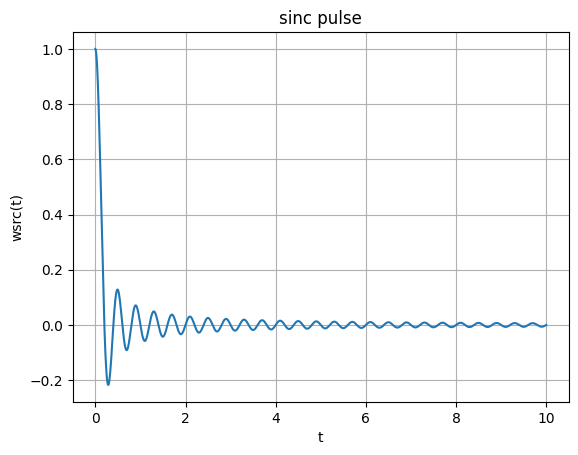

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

SincP = 5.0

t = np.linspace(0, 10 , 5000)

def wsrc(t):
    return np.sinc(SincP * t)

plt.plot(t, wsrc(t))
plt.xlabel('t')
plt.ylabel('wsrc(t)')
plt.title('sinc pulse')
plt.grid()
plt.show()


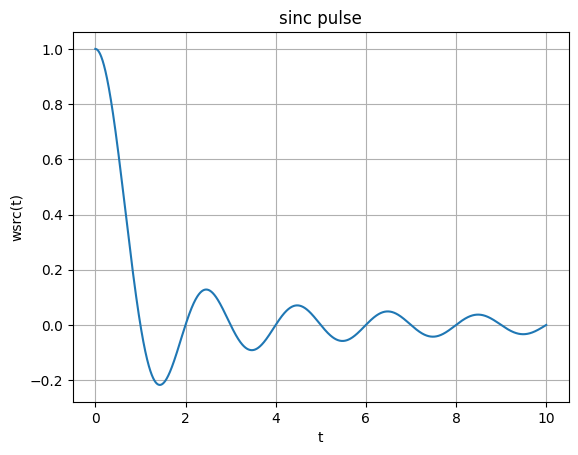

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

SincP = 1.0

t = np.linspace(0, 10, 5000)

def wsrc(t):
    return np.sinc(SincP * t)

plt.plot(t, wsrc(t))
plt.xlabel('t')
plt.ylabel('wsrc(t)')
plt.title('sinc pulse')
plt.grid()
plt.show()

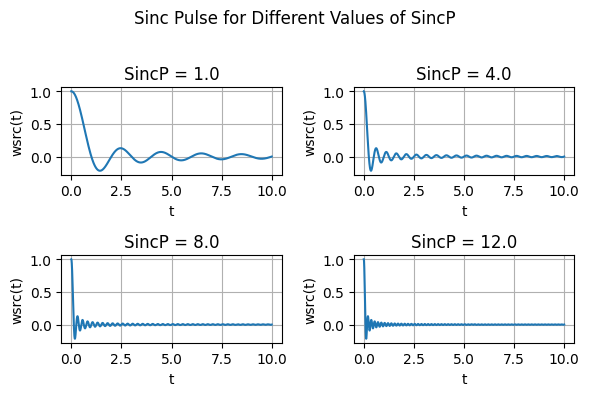

In [ ]:
SincP_values = [1.0, 4.0, 8.0, 12.0]
t = np.linspace(0, 10, 5000)

fig, axes = plt.subplots(2, 2, figsize=(6, 4))
fig.suptitle('Sinc Pulse for Different Values of SincP')

for ax, SincP in zip(axes.flat, SincP_values):
    def wsrc(t):
        return np.sinc(SincP * t)
    ax.plot(t, wsrc(t))
    ax.set_title(f'SincP = {SincP}')
    ax.set_xlabel('t')
    ax.set_ylabel('wsrc(t)')
    ax.grid()
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# DAS Algorithm

## Implementation of example given in the handout

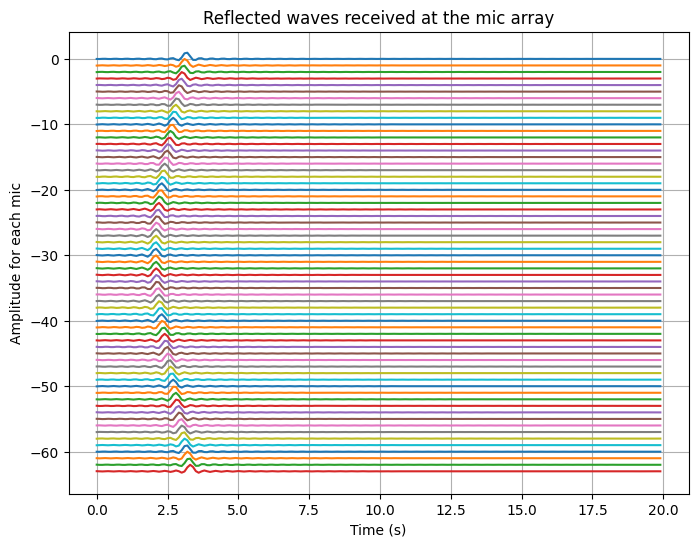

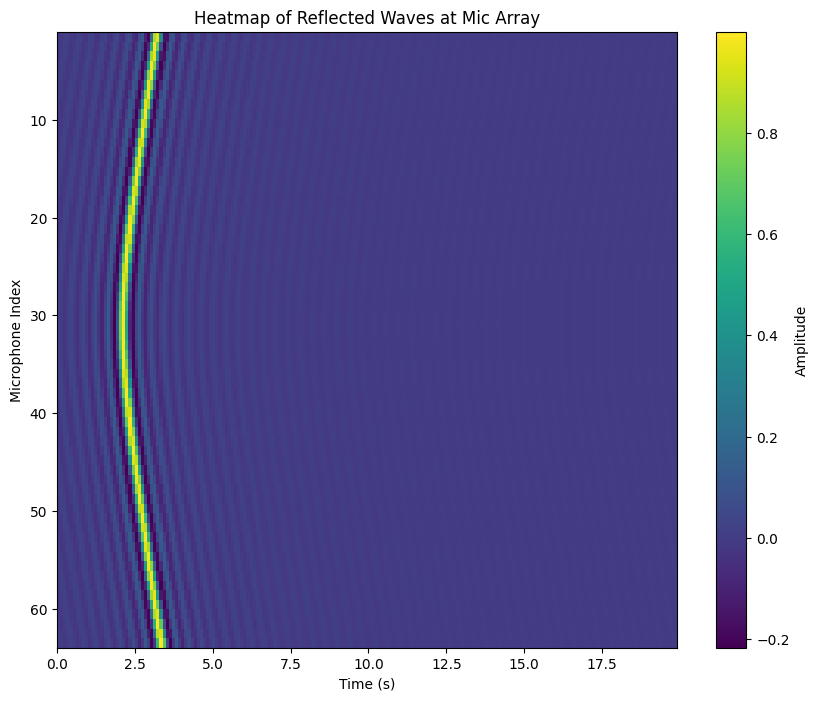

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
Nmics = 64
Nsamp = 200
src = (0, 0)
pitch = 0.1
dist_per_samp = 0.1
C = 2.0
SincP = 5.0
obstacle = (3, -1)

#microphone positions
mics = [(i * pitch, 0) for i in range(Nmics)]

#time samples
t = np.linspace(0, (Nsamp - 1) * dist_per_samp, Nsamp)

# source signal
def wsrc(t):
    return np.sinc(SincP * t)

# Distance from src to mic after reflection from the obstacle
def dist(src, obs, mic):
    d1 = np.sqrt((obs[0] - src[0])**2 + (obs[1] - src[1])**2)
    d2 = np.sqrt((mic[0] - obs[0])**2 + (mic[1] - obs[1])**2)
    return d1 + d2

mic_samples = []
for mic in mics:
    total_distance = dist(src, obstacle, mic)
    time_delay = total_distance / C
    shifted_t = t - time_delay

    #signal with the shifted time axis
    mic_signal = wsrc(shifted_t)
    mic_samples.append(mic_signal)

mic_samples = np.array(mic_samples)
offset = 1.0
plt.figure(figsize=(8, 6))
for i, signal in enumerate(mic_samples):
    plt.plot(t, signal - i * offset, label=f"Microphone {i+1}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude for each mic")
plt.title("Reflected waves received at the mic array")
plt.grid()
plt.show()

plt.figure(figsize=(10, 8))
plt.imshow(mic_samples, aspect='auto', cmap='viridis', extent=[t[0], t[-1], Nmics, 1])
plt.colorbar(label='Amplitude')
plt.xlabel("Time (s)")
plt.ylabel("Microphone Index")
plt.title("Heatmap of Reflected Waves at Mic Array")
plt.show()



## Funtion for implementing DAS Algorithm

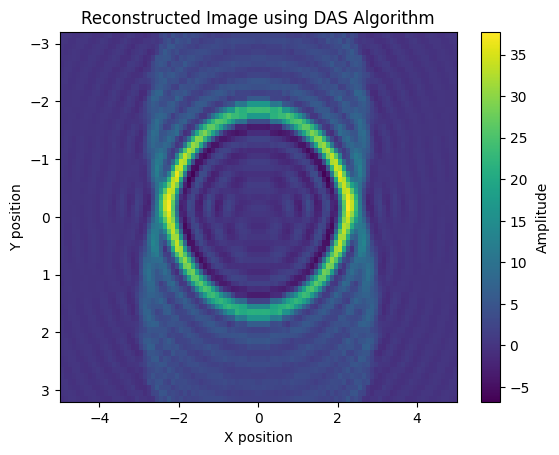

In [13]:
def das_reconstruction(src, grid_x, grid_y, mic_samples, C, dist_per_samp, mics):
    grid = np.zeros((len(grid_y), len(grid_x)))

    def dist(src, point):
        return np.sqrt((src[0] - point[0]) ** 2 + (src[1] - point[1]) ** 2)

    # DAS Algorithm
    """
    For each point in the grid and for each mic, the distance between source to point and mic to point is calculated,
    now for this distance we find out how much time it will take to travel this distance, then we find the sample index that we get by
    dividing time_delay by dist_per_samp. this translates the time delay into the equivalent number of samples that need to be skipped
    to reach the correct sample corresponding to this delay. If this is less than the total number of samples, it means the sample
    was really taken and it exists within our bounds of time (X-axis limits). So we accumulate the value of signal at that point and we repeat
    this for all the mics and collect the signal for every point in the grid and finally return the grid.
    """
    for i, x in enumerate(grid_x):
        for j, y in enumerate(grid_y):
            point = (x, y)
            sum_signal = 0
            for mic_index, mic in enumerate(mics):
                total_distance = dist(src, point) + dist(mic, point)
                time_delay = total_distance / C
                sample_index = int(time_delay / dist_per_samp)
                if 0 <= sample_index < mic_samples.shape[1]:
                    sum_signal += mic_samples[mic_index, sample_index]
            grid[j, i] = sum_signal

    return grid

mics = [(0, i * pitch) for i in range(-Nmics//2, Nmics//2)]
grid_x = np.linspace(-SincP, SincP, 100)  # x-axis ranges from -SincP to SincP
grid_y = np.linspace(-pitch * (Nmics // 2), pitch * (Nmics // 2), Nmics)  # y-axis ranges from -Nmics/2 * pitch to Nmics/2 * pitch
mic_samples = mic_samples

reconstructed_grid = das_reconstruction(src, grid_x, grid_y, mic_samples, C, dist_per_samp, mics)


plt.imshow(reconstructed_grid, aspect='auto', extent=[grid_x[0], grid_x[-1], grid_y[-1], grid_y[0]], cmap='viridis')
plt.colorbar(label="Amplitude")
plt.xlabel("X position")
plt.ylabel("Y position")
plt.title("Reconstructed Image using DAS Algorithm")

plt.show()

In [23]:
max_value = np.max(reconstructed_grid)
max_indices = np.where(reconstructed_grid == max_value)
max_y, max_x = max_indices[0][0], max_indices[1][0]
brightest_x = grid_x[max_x]
brightest_y = grid_y[max_y]

print(f"The brightest spot is at X = {brightest_x}, Y = {brightest_y}")

The brightest spot is at X = -2.272727272727273, Y = -1.9696969696969697


# Finding the obstacle for given input files

Please load in the text file given along with the assignment before executing this cell.

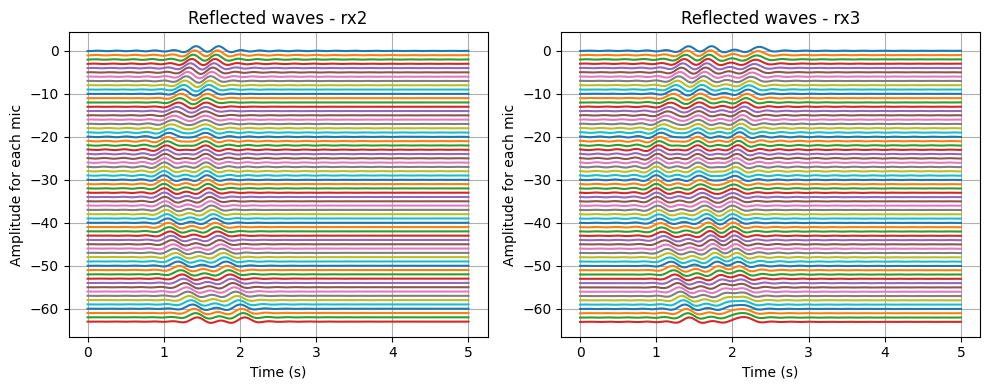

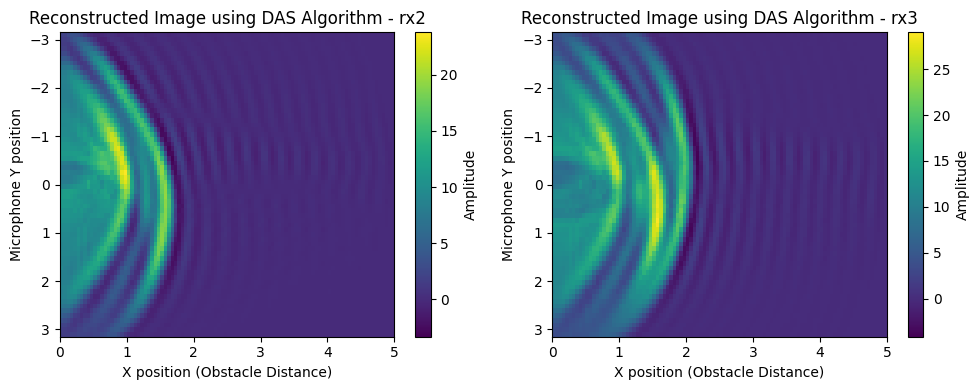

In [4]:
"""
This code tries to find the location of some obstale using the Delay-and-Sum (DAS) algorithm
on microphone data to reconstruct an image of reflected waves from two locations.
It takes in the two files attached along with the handout from two different setups and visualizes the
resulting reconstructed images.
"""

#parameters are defined
src = (0, 0)
pitch = 0.1
dist_per_samp = 0.1
C = 0.5
SincP = 5.0

#data given is loaded
mic_samples_1 = np.loadtxt('/content/rx2.txt')
mic_samples_2 = np.loadtxt('/content/rx3.txt')

Nmics = mic_samples_1.shape[0]
mics = [(0, (i - Nmics / 2) * pitch) for i in range(Nmics)]

#grid is formed and das algorithm is applied to the loaded datasets
grid_x = np.linspace(0, SincP, 100)
grid_y = np.linspace(-pitch * (Nmics / 2 - 0.5), pitch * (Nmics / 2 - 0.5), Nmics)
grid_location1 = das_reconstruction(src, grid_x, grid_y, mic_samples_1, C, dist_per_samp, mics)
grid_location2 = das_reconstruction(src, grid_x, grid_y, mic_samples_2, C, dist_per_samp, mics)

Fs = 20   #sampling frequency
Nsamp = mic_samples_1.shape[1]
t = np.linspace(0, C * Nsamp / Fs, Nsamp)  #considering the sampling frequency and taking till the distance pulse travels till nsamps are taken

#plotting of the reconstructed signal is done below
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
offset = 1.0
for i, signal in enumerate(mic_samples_1):
    plt.plot(t, signal - i * offset, label=f"Mic {i + 1}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude for each mic")
plt.title("Reflected waves - rx2")
plt.grid()

plt.subplot(1, 2, 2)
for i, signal in enumerate(mic_samples_2):
    plt.plot(t, signal - i * offset, label=f"Mic {i + 1}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude for each mic")
plt.title("Reflected waves - rx3")
plt.grid()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(grid_location1, aspect='auto', extent=[grid_x[0], grid_x[-1], grid_y[-1], grid_y[0]], cmap='viridis')
plt.colorbar(label="Amplitude")
plt.xlabel("X position (Obstacle Distance)")
plt.ylabel("Microphone Y position")
plt.title("Reconstructed Image using DAS Algorithm - rx2")

plt.subplot(1, 2, 2)
plt.imshow(grid_location2, aspect='auto', extent=[grid_x[0], grid_x[-1], grid_y[-1], grid_y[0]], cmap='viridis')
plt.colorbar(label="Amplitude")
plt.xlabel("X position (Obstacle Distance)")
plt.ylabel("Microphone Y position")
plt.title("Reconstructed Image using DAS Algorithm - rx3")
plt.tight_layout()
plt.show()


# Experimenting with different values of nmics and nsamps

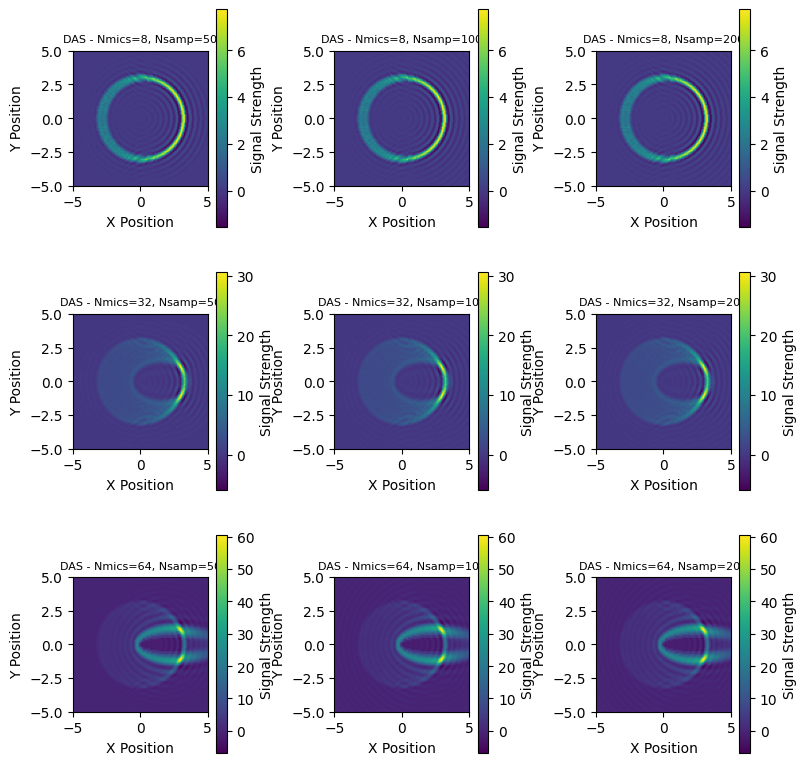

In [22]:
src = (0, 0)
pitch = 0.1
dist_per_samp = 0.1
C = 2.0
SincP = 5.0
obstacle = (3, -1)

#list of nmics and nsamps defined
Nmics_values = [8, 32, 64]
Nsamp_values = [50, 100, 200]

grid_x = np.linspace(-5, 5, 100)
grid_y = np.linspace(-5, 5, 100)
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

#for each combination of nmics and nsamps, mic samples are generated using wsrc function we defined earlier for generating sinc pulses and reconstruction is done and plotted
index = 0
for Nmics in Nmics_values:
    for Nsamp in Nsamp_values:
        mics = [(i * pitch, 0) for i in range(Nmics)]
        t = np.linspace(0, (Nsamp - 1) * dist_per_samp, Nsamp)

        mic_samples = []
        for mic in mics:
            total_distance = dist(src, obstacle, mic)
            time_delay = total_distance / C
            shifted_t = t - time_delay
            mic_signal = wsrc(shifted_t)
            mic_samples.append(mic_signal)

        mic_samples = np.array(mic_samples)
        grid = das_reconstruction(src, grid_x, grid_y, mic_samples, C, dist_per_samp, mics)
        ax = axes[index // 3, index % 3]

        im = ax.imshow(grid, extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()], origin='lower', cmap='viridis')
        ax.set_title(f'DAS - Nmics={Nmics}, Nsamp={Nsamp}', fontsize=8)
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        fig.colorbar(im, ax=ax, label='Signal Strength')

        index += 1


plt.tight_layout()
plt.show()